In [1]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'STARE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])

In [3]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,2.0,1.0,34.0,8.0,4.0,1.0,9.0,8.0,16.0,13.319445,435.929322,2814.026020,1180.116262,4.0,2.0,6.0,6.0
1,2.0,9.0,34.0,8.0,4.0,9.0,9.0,8.0,34.0,15.734363,435.929322,2814.026020,1180.116262,1.0,1.0,4.0,2.0
2,2.0,1.0,33.0,8.0,4.0,1.0,9.0,35.0,27.0,17.688118,476.146390,2814.026020,1180.116262,1.0,1.0,2.0,2.0
3,2.0,1.0,33.0,8.0,4.0,9.0,11.0,35.0,35.0,17.953630,476.146390,2814.026020,1180.116262,1.0,1.0,2.0,2.0
4,2.0,1.0,34.0,8.0,4.0,9.0,9.0,8.0,16.0,15.904023,452.490523,2851.723549,1180.116262,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311427,2.0,15.0,34.0,34.0,4.0,8.0,8.0,8.0,16.0,1.275444,268.644137,376.316963,698.043640,1.0,1.0,0.0,1.0
311428,2.0,9.0,34.0,34.0,4.0,8.0,8.0,16.0,8.0,0.662995,227.281819,376.316963,698.043640,1.0,1.0,1.0,0.0
311429,2.0,0.0,34.0,33.0,8.0,2.0,16.0,4.0,16.0,6.923911,263.756787,351.412729,663.569928,2.0,2.0,2.0,1.0
311430,2.0,1.0,34.0,33.0,8.0,8.0,8.0,16.0,8.0,11.219486,263.756787,351.412729,663.569928,1.0,1.0,1.0,0.0


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,2.0,1.0,34.0,8.0,4.0,0.0,1.0,24.0,34.0,28.860241,1469.820661,3298.084521,3593.663271,1.0,4.0,5.0,5.0
1,2.0,27.0,34.0,8.0,4.0,1.0,0.0,21.0,8.0,80.331802,489.009098,2822.180441,3334.528172,10.0,4.0,12.0,26.0
2,2.0,4.0,27.0,8.0,4.0,9.0,9.0,34.0,35.0,96.012170,1019.685330,3782.498868,3334.528172,8.0,4.0,8.0,2.0
3,2.0,8.0,27.0,8.0,4.0,1.0,9.0,34.0,35.0,133.257429,1019.685330,3782.498868,3334.528172,3.0,3.0,2.0,1.0
4,2.0,27.0,35.0,8.0,4.0,1.0,9.0,35.0,34.0,140.700696,1276.139007,3782.498868,3334.528172,3.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312886,2.0,16.0,33.0,4.0,8.0,16.0,16.0,34.0,35.0,17.781339,1552.599793,2307.878364,3398.864915,2.0,3.0,0.0,0.0
312887,2.0,8.0,33.0,4.0,8.0,16.0,16.0,35.0,35.0,23.727390,1552.599793,2307.878364,3398.864915,3.0,3.0,0.0,0.0
312888,2.0,4.0,34.0,4.0,8.0,16.0,16.0,35.0,35.0,23.245196,1525.101493,2307.878364,3398.864915,3.0,3.0,0.0,0.0
312889,2.0,8.0,34.0,4.0,8.0,16.0,16.0,35.0,34.0,21.953441,1525.101493,2307.878364,3398.864915,3.0,2.0,0.0,0.0


In [4]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9283835323243338

F1 score: 0.5470511547476713

Confusion matrix:

     t/p    0.0   1.0 
      0.0 828759 20202 
      1.0 46853 40493 
Sensivity: 0.4635930666544547
Specificity: 0.976203853887281
-------------------------------------
Accuracy score: 0.9261529989921973

F1 score: 0.5681913452367211

Confusion matrix:

     t/p    0.0   1.0 
      0.0 844650 18700 
      1.0 52377 46763 
Sensivity: 0.47168650393383094
Specificity: 0.9783401864828865
-------------------------------------
Accuracy score: 0.9465205745142603

F1 score: 0.7328713410047533

Confusion matrix:

     t/p    0.0   1.0 
      0.0 817543 19897 
      1.0 30176 68688 
Sensivity: 0.6947726169283055
Specificity: 0.9762406858998853
-------------------------------------
Accuracy score: 0.9461475615551794

F1 score: 0.728300402497966

Confusion matrix:

     t/p    0.0   1.0 
      0.0 818347 21020 
      1.0 29405 67583 
Sensivity: 0.6968181630717202
Specificity: 0.9749573190273146
-------------------

{'acc': 0.9371820364601465, 'f1': 0.6577268426993362}

In [5]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16558520630879009_stare/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

In [6]:
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'y_train': y_train,
})

Accuracy score: 0.9362036169760559

F1 score: 0.6193192319212802

Confusion matrix:

     t/p    0.0   1.0 
      0.0 827985 20976 
      1.0 38757 48589 
Sensivity: 0.5562819133102832
Specificity: 0.9752921512295618
-------------------------------------
Accuracy score: 0.9253041590042494

F1 score: 0.5726852347158329

Confusion matrix:

     t/p    0.0   1.0 
      0.0 842420 20930 
      1.0 50964 48176 
Sensivity: 0.48593907605406494
Specificity: 0.9757572247640007
-------------------------------------
Accuracy score: 0.9519002375296912

F1 score: 0.774187725631769

Confusion matrix:

     t/p    0.0   1.0 
      0.0 814066 23374 
      1.0 21662 77202 
Sensivity: 0.7808909208609808
Specificity: 0.9720887466564769
-------------------------------------
Accuracy score: 0.9494112809778342

F1 score: 0.7685602747824557

Confusion matrix:

     t/p    0.0   1.0 
      0.0 810335 29032 
      1.0 18337 78651 
Sensivity: 0.8109353734482616
Specificity: 0.9654120307326831
------------------

{'acc': 0.943138012208409, 'f1': 0.7035313765786138}

In [7]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

Columns: Index([ 'Original_green_lbp_g',   '1:1_riu_green_lbp_g',
         '1:2_riu_green_lbp_g',   '1:4_riu_green_lbp_g',
         '1:8_riu_green_lbp_g', '2:1_1_riu_green_lbp_g',
       '2:1_2_riu_green_lbp_g', '2:1_3_riu_green_lbp_g',
       '2:1_4_riu_green_lbp_g',   '1:1_var_green_lbp_g',
         '1:2_var_green_lbp_g',   '1:4_var_green_lbp_g',
         '1:8_var_green_lbp_g', '2:1_1_var_green_lbp_g',
       '2:1_2_var_green_lbp_g', '2:1_3_var_green_lbp_g',
       '2:1_4_var_green_lbp_g',                       0,
                             1,                       2,
                             3,                       4,
                             5],
      dtype='object')


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


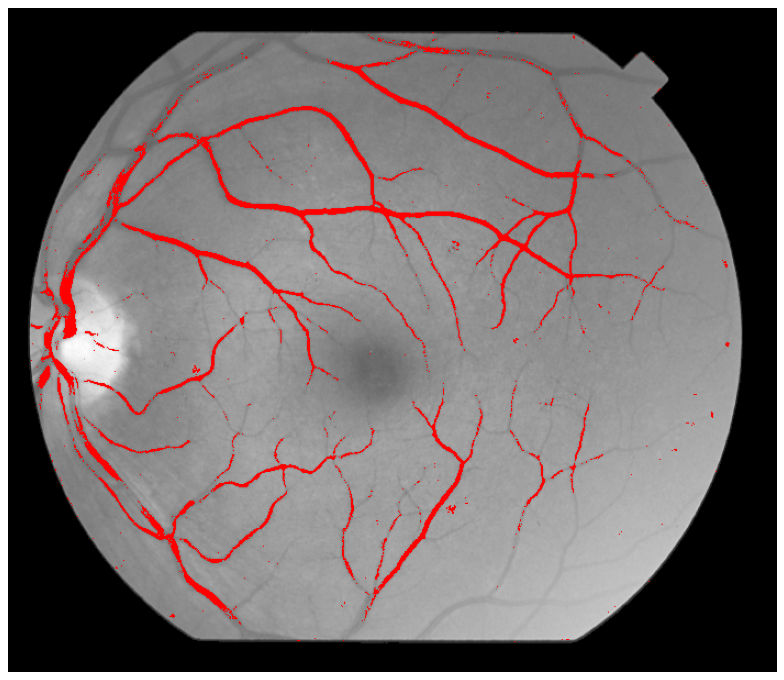

Accuracy score: 0.939882166096764

F1 score: 0.603722692508134

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1673694 12631 
      1.0 99907 85725 
Sensivity: 0.4618007671091191
Specificity: 0.9925097475279083


(0.94, 0.604, 1673694, 12631, 99907, 85725)

In [8]:
features = {
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'x_test': pd.concat([df_test, conv_features_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

from main import main
PARAMETERS.PLOT = True

main(lgb='Num', features=features, plot_once=True, recurrence=True)